In [ ]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


In [ ]:
# Устанавливаем библиотеки
!pip install kaggle opencv-python-headless tensorflow numpy

# Удаляем папку, если она уже существует, чтобы избежать конфликтов
!rm -rf dataset/people_segmentation

# Загружаем Kaggle API токен
from google.colab import files
files.upload()  # Загрузите сюда kaggle.json

# Настраиваем доступ к Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Скачиваем датасет
!kaggle datasets download -d nikhilroxtomar/person-segmentation

# Распаковываем с перезаписью
!unzip -o person-segmentation.zip -d dataset


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/people_segmentation/masks/pexels-photo-108155.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-108157.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-108261.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-108292.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-109002.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-109394.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-109547_rIJj622db8.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-109669.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-10979.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-109851.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-10988.png  
  inflating: dataset/people_segmentation/masks/pexels-photo-109917.png  
  inflating: dataset/people_segmentation/masks/

In [ ]:
import os
from glob import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Пути к изображениям и маскам
data_path = "dataset/people_segmentation"
images_path = sorted(glob(os.path.join(data_path, 'images/*.jpg')))
masks_path = sorted(glob(os.path.join(data_path, 'masks/*.png')))

# Разделение данных на обучающую и тестовую выборки
train_images, test_images, train_masks, test_masks = train_test_split(
    images_path, masks_path, test_size=0.2, random_state=42
)

# Функции для чтения и обработки изображений
def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))  # Изменяем размер изображения
    image = image / 255.0  # Нормализация в диапазон [0, 1]
    return image.astype(np.float32)

def read_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))  # Изменяем размер маски
    mask = mask / 255.0  # Приведение значений к диапазону [0, 1]
    mask = np.expand_dims(mask, axis=-1)  # Добавляем канал
    return mask.astype(np.float32)


In [ ]:
import tensorflow as tf

# Преобразование путей в изображения и маски
def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image = read_image(image_path.decode())
        mask = read_mask(mask_path.decode())
        return image, mask

    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask

# Создаем TensorFlow Dataset
def tf_dataset(images, masks, batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Создание обучающего и тестового датасета
train_dataset = tf_dataset(train_images, train_masks, batch_size=8)
val_dataset = tf_dataset(test_images, test_masks, batch_size=8)


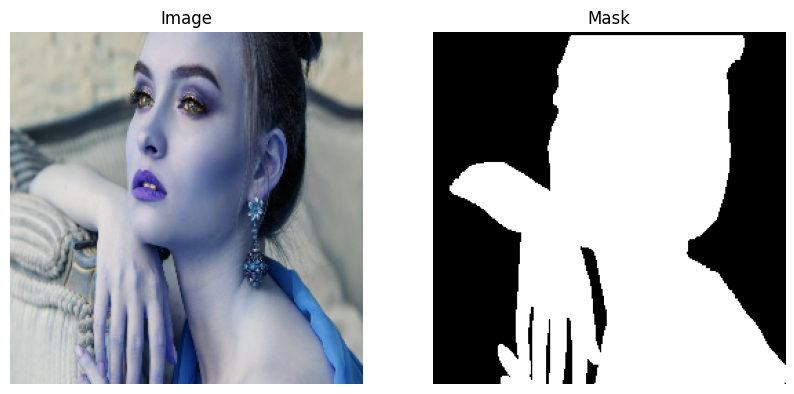

In [ ]:
import matplotlib.pyplot as plt

# Визуализируем одно изображение и соответствующую маску
for image, mask in train_dataset.take(1):
    plt.figure(figsize=(10, 5))

    # Изображение
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].numpy())
    plt.title("Image")
    plt.axis("off")

    # Маска
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0].numpy().squeeze(), cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.show()


## Build UNet Architecture

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    return Model(inputs, outputs, name="U-Net")

In [ ]:
def load_data(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))
    train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)
    return (train_x, train_y), (test_x, test_y)

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    # (256, 256, 3)
    return x

In [ ]:
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()
        x = read_image(image_path)
        y = read_mask(mask_path)
        return x, y
    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask

In [ ]:
def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()  # Повторяем данные бесконечно
    dataset = dataset.prefetch(2)
    return dataset


### Train the model

In [ ]:
""" Импорты """
from tensorflow.keras.layers import Input  # Добавлено
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

""" Гиперпараметры """
dataset_path = "./dataset"  # Путь к вашим данным
input_shape = (256, 256, 3)  # Размер входного изображения
batch_size = 8  # Размер батча
epochs = 10  # Количество эпох
lr = 1e-4  # Скорость обучения
model_path = "./unet_model.keras"  # Сохранение модели в формате .keras
csv_path = "./training_log.csv"  # Логирование обучения

""" Функция загрузки данных """
def load_data(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "people_segmentation/images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "people_segmentation/masks/*")))

    # Проверка, что данные загружены
    assert len(images) > 0, "Папка images пуста или путь указан неверно"
    assert len(masks) > 0, "Папка masks пуста или путь указан неверно"

    train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)
    return (train_x, train_y), (test_x, test_y)

""" Загрузка датасета """
# Загрузка путей к данным
(train_x, train_y), (test_x, test_y) = load_data(dataset_path)

# Преобразование данных в формат TensorFlow Dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)

""" Построение модели """
model = build_unet(input_shape)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
)

""" Колбэки """
callbacks = [
    ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]

""" Определение количества шагов """
train_steps = len(train_x) // batch_size
if len(train_x) % batch_size != 0:
    train_steps += 1

valid_steps = len(test_x) // batch_size
if len(test_x) % batch_size != 0:
    valid_steps += 1

""" Запуск обучения """
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)


Epoch 1/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - loss: 0.4535 - mean_io_u: 0.2668 - precision: 0.5989 - recall: 0.5800
Epoch 1: val_loss improved from inf to 0.36398, saving model to ./unet_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 440s 639ms/step - loss: 0.4534 - mean_io_u: 0.2668 - precision: 0.5991 - recall: 0.5801 - val_loss: 0.3640 - val_mean_io_u: 0.2500 - val_precision: 0.6572 - val_recall: 0.8021 - learning_rate: 1.0000e-04
Epoch 2/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.3115 - mean_io_u: 0.2679 - precision: 0.7511 - recall: 0.6994
Epoch 2: val_loss did not improve from 0.36398
568/568 ━━━━━━━━━━━━━━━━━━━━ 307s 541ms/step - loss: 0.3115 - mean_io_u: 0.2679 - precision: 0.7512 - recall: 0.6994 - val_loss: 0.3948 - val_mean_io_u: 0.2594 - val_precision: 0.6432 - val_recall: 0.8648 - learning_rate: 1.0000e-04
Epoch 3/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.2738 - mean_io_u: 0.2662 - precision: 0.7898 - recall: 0.7531
Epoch 3: val_loss did not 

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.metrics import MeanIoU, Recall, Precision
from sklearn.model_selection import train_test_split
import cv2
from glob import glob

# Путь к данным
data_path = "dataset/people_segmentation"
images_path = sorted(glob(os.path.join(data_path, 'images/*.jpg')))
masks_path = sorted(glob(os.path.join(data_path, 'masks/*.png')))
train_images, test_images, train_masks, test_masks = train_test_split(images_path, masks_path, test_size=0.2, random_state=42)

# Функции для чтения изображений и масок
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0  # Нормализация
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)  # Добавляем размерность
    return x

# Функция для предобработки данных
def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()  # Декодируем путь к изображению
        mask_path = mask_path.decode()  # Декодируем путь к маске
        x = read_image(image_path)  # Читаем и обрабатываем изображение
        y = read_mask(mask_path)  # Читаем и обрабатываем маску
        return x, y

    # Используем tf.numpy_function для обработки
    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])  # Для изображений RGB
    mask.set_shape([256, 256, 1])  # Для масок (1 канал)
    return image, mask

# Создаем датасет
def tf_dataset(images, masks, batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Строим модель SegNet
def build_segnet(input_shape=(256, 256, 3), num_classes=1):
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
    from tensorflow.keras.models import Model

    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Decoder
    u3 = UpSampling2D((2, 2))(p3)
    d3 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    d3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d3)

    u2 = UpSampling2D((2, 2))(d3)
    d2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    d2 = Conv2D(128, (3, 3), activation='relu', padding='same')(d2)

    u1 = UpSampling2D((2, 2))(d2)
    d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(d1)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d1)

    model = Model(inputs, outputs, name="SegNet")
    return model

# Обучение модели
def train_model(model, train_dataset, val_dataset, epochs=10, model_name="segnet_model"):
    # Определяем метрики
    metrics = [
        'accuracy',
        MeanIoU(num_classes=2),
        Recall(),
        Precision()
    ]

    # Компилируем модель
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

    # Директория для сохранения модели и метрик
    if not os.path.exists("models"):
        os.makedirs("models")

    # Определяем колбэки для сохранения модели и метрик
    model_checkpoint = ModelCheckpoint(
        os.path.join("models", f"{model_name}.keras"),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    csv_logger = CSVLogger(os.path.join("models", f"{model_name}_metrics.csv"))

    # Обучаем модель
    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[model_checkpoint, csv_logger]
    )

# Создание датасетов
train_dataset = tf_dataset(train_images, train_masks, batch_size=8)
val_dataset = tf_dataset(test_images, test_masks, batch_size=8)

# Создаем модель SegNet
segnet_model = build_segnet()

print("Training SegNet model...")
train_model(segnet_model, train_dataset, val_dataset, epochs=10, model_name="segnet_model")


Training SegNet model...
Epoch 1/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7472 - loss: 0.5370 - mean_io_u_1: 0.2678 - precision_1: 0.4635 - recall_1: 0.1158
Epoch 1: val_loss improved from inf to 0.46811, saving model to models/segnet_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 184s 313ms/step - accuracy: 0.7472 - loss: 0.5369 - mean_io_u_1: 0.2678 - precision_1: 0.4637 - recall_1: 0.1160 - val_accuracy: 0.7545 - val_loss: 0.4681 - val_mean_io_u_1: 0.2500 - val_precision_1: 0.7162 - val_recall_1: 0.0663
Epoch 2/10
568/568 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7857 - loss: 0.4431 - mean_io_u_1: 0.2675 - precision_1: 0.5969 - recall_1: 0.4747
Epoch 2: val_loss did not improve from 0.46811
568/568 ━━━━━━━━━━━━━━━━━━━━ 164s 289ms/step - accuracy: 0.7857 - loss: 0.4431 - mean_io_u_1: 0.2675 - precision_1: 0.5970 - recall_1: 0.4747 - val_accuracy: 0.7329 - val_loss: 0.4850 - val_mean_io_u_1: 0.2500 - val_precision_1: 0.4866 - val_recall_1: 0.8111
Epoch 3/10
568/568

In [22]:
import cv2
import numpy as np
import time
import os
from tensorflow.keras.models import load_model

# Загружаем модель U-Net
unet_model = load_model('/content/unet_model.keras')  # Указываем правильный путь к модели

# Функция сегментации кадра и наложения на фон для U-Net
def segment_frame(model, frame, background_color, img_size=(256, 256)):
    # Предобработка кадра
    input_img = cv2.resize(frame, img_size) / 255.0
    input_img = np.expand_dims(input_img, axis=0)

    # Предсказание маски
    mask = model.predict(input_img)[0]
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
    mask = (mask > 0.5).astype(np.uint8)  # бинаризация маски

    # Наложение чёрного фона
    mask_rgb = np.stack([mask] * 3, axis=-1)  # преобразование маски в RGB
    background = np.full_like(frame, background_color)  # создаём чёрный фон
    segmented_frame = np.where(mask_rgb == 1, frame, background)
    return segmented_frame

# Функция для обработки видео с моделью U-Net
def process_video_unet(input_path, output_name, model, background_color=(0, 0, 0), img_size=(256, 256)):
    if not os.path.exists("videos"):
        os.makedirs("videos")

    # Открываем входное видео
    cap = cv2.VideoCapture(input_path)

    # Получаем параметры видео
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Инициализируем объект записи видео
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(os.path.join("videos", f"{output_name}.mp4"), fourcc, fps, (frame_width, frame_height))

    # Измерение времени обработки видео
    start_time = time.time()

    # Переменная для подсчета кадров
    frame_count = 0

    # Обработка каждого кадра
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Измерение времени обработки одного кадра
        frame_start_time = time.time()

        # Преобразуем и сегментируем кадр
        segmented_frame = segment_frame(model, frame, background_color, img_size)

        # Записываем обработанный кадр в выходное видео
        out.write(segmented_frame)

        # Подсчёт времени обработки кадра
        frame_end_time = time.time()
        frame_processing_time = frame_end_time - frame_start_time
        frame_count += 1

    end_time = time.time()
    processing_time = end_time - start_time
    cap.release()
    out.release()

    # Вычисление FPS
    fps_calculated = frame_count / processing_time
    print(f"Время обработки видео {output_name} заняло: {processing_time:.2f} секунд")
    print(f"Скорость обработки: {fps_calculated:.2f} FPS")

# Задаём путь и запускаем обработку для U-Net
input_video_path = '/content/Видео для моделей.mp4'  # Путь к вашему видео
output_name = "unet_output"
background_color = (0, 0, 0)  # Черный фон

# Используем модель U-Net для обработки видео
print("Processing with U-Net model...")
process_video_unet(input_video_path, output_name, unet_model, background_color)


Processing with U-Net model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [23]:
import os

# Проверим, существует ли файл
print(os.path.exists('/content/videos/unet_output.mp4'))


True


In [24]:
from google.colab import drive
import shutil

# Монтируем Google Drive
drive.mount('/content/drive')

# Перемещаем файл в Google Drive
shutil.move('/content/videos/unet_output.mp4', '/content/drive/My Drive/unet_output.mp4')


Mounted at /content/drive


'/content/drive/My Drive/unet_output.mp4'

In [25]:
import cv2
import numpy as np
import time
import os
from tensorflow.keras.models import load_model

# Загружаем модель SegNet
segnet_model = load_model('/content/models/segnet_model.keras')  # Указан правильный путь к модели

# Функция сегментации кадра и наложения на фон для SegNet
def segment_frame(model, frame, background_color, img_size=(256, 256)):
    # Предобработка кадра
    input_img = cv2.resize(frame, img_size) / 255.0
    input_img = np.expand_dims(input_img, axis=0)

    # Предсказание маски
    mask = model.predict(input_img)[0]
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
    mask = (mask > 0.5).astype(np.uint8)  # бинаризация маски

    # Наложение чёрного фона
    mask_rgb = np.stack([mask] * 3, axis=-1)  # преобразование маски в RGB
    background = np.full_like(frame, background_color)  # создаём чёрный фон
    segmented_frame = np.where(mask_rgb == 1, frame, background)
    return segmented_frame

# Функция для обработки видео с моделью SegNet
def process_video_segnet(input_path, output_name, model, background_color=(0, 0, 0), img_size=(256, 256)):
    if not os.path.exists("videos"):
        os.makedirs("videos")

    # Открываем входное видео
    cap = cv2.VideoCapture(input_path)

    # Получаем параметры видео
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Инициализируем объект записи видео
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(os.path.join("videos", f"{output_name}.mp4"), fourcc, fps, (frame_width, frame_height))

    # Измерение времени обработки видео
    start_time = time.time()

    # Переменная для подсчета кадров
    frame_count = 0

    # Обработка каждого кадра
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Измерение времени обработки одного кадра
        frame_start_time = time.time()

        # Преобразуем и сегментируем кадр
        segmented_frame = segment_frame(model, frame, background_color, img_size)

        # Записываем обработанный кадр в выходное видео
        out.write(segmented_frame)

        # Подсчёт времени обработки кадра
        frame_end_time = time.time()
        frame_processing_time = frame_end_time - frame_start_time
        frame_count += 1

    end_time = time.time()
    processing_time = end_time - start_time
    cap.release()
    out.release()

    # Вычисление FPS
    fps_calculated = frame_count / processing_time
    print(f"Время обработки видео {output_name} заняло: {processing_time:.2f} секунд")
    print(f"Скорость обработки: {fps_calculated:.2f} FPS")

# Задаём путь и запускаем обработку для SegNet
input_video_path = '/content/Видео для моделей.mp4'  # Путь к вашему видео
output_name = "segnet_output"
background_color = (0, 0, 0)  # Черный фон

# Используем модель SegNet для обработки видео
print("Processing with SegNet model...")
process_video_segnet(input_video_path, output_name, segnet_model, background_color)


Processing with SegNet model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━

In [26]:
import os

# Проверим, существует ли файл
print(os.path.exists('/content/videos/segnet_output.mp4'))


True


In [27]:
from google.colab import drive
import shutil

# Монтируем Google Drive
drive.mount('/content/drive')

# Перемещаем файл в Google Drive
shutil.move('/content/videos/segnet_output.mp4', '/content/drive/My Drive/segnet_output.mp4')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/segnet_output.mp4'

Ссылка на гугл диск с исходным видео и видео после обработки моделями: https://drive.google.com/drive/folders/1UYjLDHcOdY7o401tBp2-ae51fQeXcMwQ?usp=sharing